In [1]:
# LEGEND specific imports
from lgdo import lh5, VectorOfVectors, WaveformTable, Table, ArrayOfEqualSizedArrays, Array
from lgdo.lh5 import LH5Store
from dspeed import build_dsp

# P-ONE fastDAQ decoder
from eng_reader import EngFormatReader

# MISC
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import glob


In [4]:
# Just some paths
DAQ_PATH = "../data/gain_cal/daq/"
RAW_PATH = "../data/gain_cal/raw/"
DSP_PATH = "../data/gain_cal/dsp/"

# Hello Waveforms!

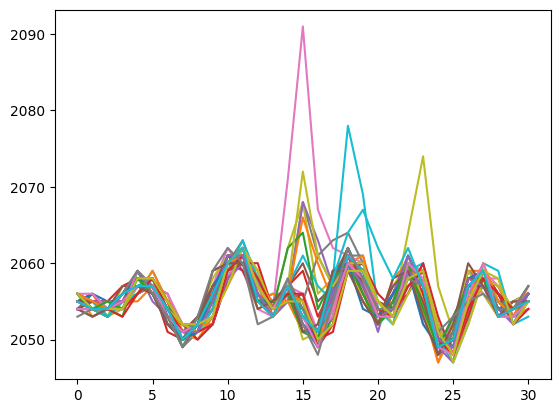

In [5]:
f = open(DAQ_PATH+"gain_cal_95.txt")
r = EngFormatReader(f)

for i in range(50):
    readout_test=r.read_next_trigger()
    if r.eof:break
    plt.plot(readout_test.waveforms[2][1:])
plt.show()

# Write P-One txt data to LEGEND raw format

We call the decoder on some MSU testdata
The data contains two relevant channels: channel 2 and channel 13

In [14]:
f = open(DAQ_PATH+"gain_cal_95.txt")

r = EngFormatReader(f)
signal={"ch002":[],"ch013":[]} # init a list for each channel to which we will write the waveforms
while True:
    readout_test=r.read_next_trigger()
    if r.eof:break
    # append the list of samples from each waveform to the list of waveforms
    # --> not very elegant, but does the trick for testing
    signal["ch002"].append(readout_test.waveforms[2])
    signal["ch013"].append(readout_test.waveforms[13])
    

Now we convert our waveforms into LEGEND data type and write it out to disk

In [15]:
f_raw = RAW_PATH + "pone_meets_legend_gain_95_raw.lh5"
for k in signal.keys():
    # lets convert the list of list into a rectangular structure (fingers crossed all entries have the same length)
    a = ArrayOfEqualSizedArrays(nda=np.array(signal[k],dtype=np.uint16)) 
    
    # Lets utilize one of the LEGEND specific data objects.
    # WaveformTable takes a rectangular array or a VectorOfVector (in case we have waveforms with different lengths)
    # and assigns sampling rate (here 4.8 ns), t_0 offset and units
    b = WaveformTable(values=a,dt=4.8,dt_units="ns",t0=0,t0_units="ns")
    
    # add everything into a lh5 structure and write it to disk
    table = Table(size=len(b))
    table.add_field("waveform",b,True)
    lh5.write(table,name="raw",group=k,lh5_file=f_raw)

Lets look what we have done.
the show command allows to view the files structure.
Hopefully we set it up in a way that it is understandable for anybody seeing this

In [16]:
f_raw = RAW_PATH + "pone_meets_legend_gain_95_raw.lh5"
lh5.show(f_raw,attrs=True)

/
├── ch002 · HDF5 group 
│   └── raw · table{waveform} 
│       └── waveform · table{t0,dt,values} 
│           ├── dt · array<1>{real} ── {'units': 'ns'}
│           ├── t0 · array<1>{real} ── {'units': 'ns'}
│           └── values · array_of_equalsized_arrays<1,1>{real} 
└── ch013 · HDF5 group 
    └── raw · table{waveform} 
        └── waveform · table{t0,dt,values} 
            ├── dt · array<1>{real} ── {'units': 'ns'}
            ├── t0 · array<1>{real} ── {'units': 'ns'}
            └── values · array_of_equalsized_arrays<1,1>{real} 


# RAW to DSP, signal processing on the fly

Ok. Now comes the fun part: Processing our waveforms!
First we define a processing configuration and outputs.
Here we do
- hermetic spline upsampling of the waveform to 1 ns
- apply an average fillter to remove some noise
- find the baseline by applying a linear fit to the first four samples of the waveform
- substracting the baseline from the waveform
- finding global extrema
- Building a +1 15 ns coincidence window around the maximum
- integrate the waveform insite the coincidence window
- Picking of the maximum of the integral --> charge

In [17]:
config = {
    "outputs": [
        "tp_max",
        "wf_max",
        "charge",
    ],
    "processors":{
        "wf_up": {
            "function": "interpolating_upsampler",
            "module": "dspeed.processors",
            "args": ["waveform", "'h'", "wf_up(len(waveform)*4.8, period=waveform.period/4.8)"],
            "unit": "ADC"
        },
        "wf_av": {
          "function": "moving_window_multi",
          "module": "dspeed.processors",
          "args": ["wf_up", "4", "4", "0", "wf_av"],
          "unit": "ADC/sample"
        },
       "wf_blsub": {
            "function": "subtract",
            "module": "numpy",
            "args": ["wf_av", "2055", "wf_blsub"],
            "unit": "ADC",
        },
        "tp_min, tp_max, wf_min, wf_max": {
            "function": "min_max",
            "module": "dspeed.processors",
            "args": ["wf_blsub", "tp_min", "tp_max", "wf_min", "wf_max"],
            "unit": ["ns", "ns", "ADC", "ADC"]
        },
        "wf_coin": {
          "function": "windower",
          "module": "dspeed.processors",
          "args": [
            "wf_blsub",
            "tp_max-15*ns",
            "wf_coin(shape=round(30*ns/wf_blsub.period), period=wf_blsub.period, offset=(tp_max-15*ns)/wf_blsub.period)"
          ],
          "unit": ["ADC"]
        },
        "wf_cum_coin": {
          "function": "cumsum",
          "module": "numpy",
          "args": ["wf_coin", 1,"None","wf_cum_coin"],
          "kwargs": {"signature": "(n),(),()->(n)", "types": ["fii->f"]},
          "unit": "ADC"
        },
        "tp_min_int, tp_max_int, wf_min_int, charge": {
            "function": "min_max",
            "module": "dspeed.processors",
            "args": ["wf_cum_coin", "tp_min_int", "tp_max_int", "wf_min_int", "charge"],
            "unit": ["ns", "ns", "ADC", "ADC"]
        },
    }
}



LEGENDs signal processing package (dspeed) includes a WaveformBrowser with which we can apply processors from our above configuration on the fly, and look at the output.
Lets plot on of the upsampled, baseline substracted waveforms and mark the maximum 

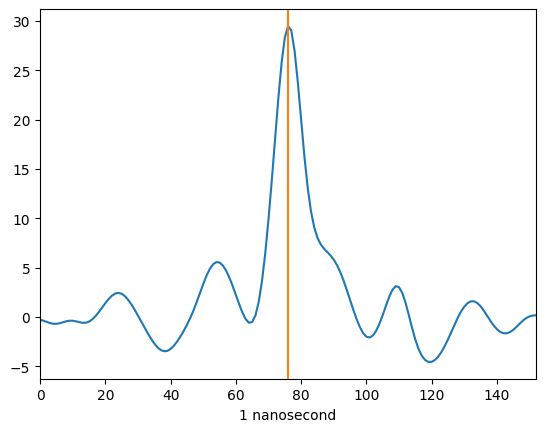

In [18]:
from dspeed.vis import WaveformBrowser
entry_no=6
browser = WaveformBrowser(
    RAW_PATH + "pone_meets_legend_gain_95_raw.lh5",
    "ch002/raw",
    dsp_config=config,
    lines=["wf_blsub","tp_max"],
    # styles=[
    #     {"color": ["r"], "ls": ["dotted"]},
        # {"color": ["g"], "ls": ["dotted"]}, 
        # {"color": ["skyblue"] , "ls": ["dotted"]},
    # ],
    # y_lim=(-10, 100),
)
browser.draw_entry(entry_no)

Now that we are happy with our processing chain. We need only one more line to create our DSP level

In [19]:
f_raw = glob.glob(RAW_PATH+"*")

for f in f_raw:
    f_dsp = f.replace("raw","dsp")
    build_dsp(
        f_raw=f,
        f_dsp=f_dsp,
        dsp_config=config,
        write_mode="o",
    )

Lets have a look into our created dsp file!

In [20]:
f_dsp = DSP_PATH + "pone_meets_legend_gain_95_dsp.lh5"
lh5.show(f_dsp,attrs=True)

/
├── ch002 · HDF5 group 
│   └── dsp · table{tp_max,wf_max,charge} 
│       ├── charge · array<1>{real} ── {'units': 'ADC'}
│       ├── tp_max · array<1>{real} ── {'units': 'ns'}
│       └── wf_max · array<1>{real} ── {'units': 'ADC'}
└── ch013 · HDF5 group 
    └── dsp · table{tp_max,wf_max,charge} 
        ├── charge · array<1>{real} ── {'units': 'ADC'}
        ├── tp_max · array<1>{real} ── {'units': 'ns'}
        └── wf_max · array<1>{real} ── {'units': 'ADC'}


Lets also plot the p.e. spectra.

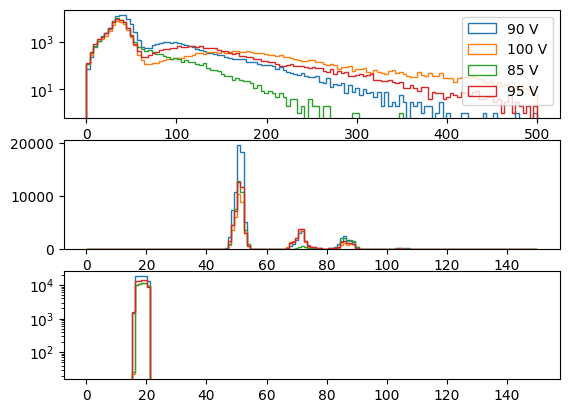

In [22]:
f_dsp = glob.glob(DSP_PATH+"*.lh5")

fig, ax = plt.subplots(3)
for f in f_dsp:
    voltage= f.split("_")[-2]

    trig_dsp = lh5.read_as("ch013/dsp",f,"ak")
    pmt_dsp = lh5.read_as("ch002/dsp",f,"ak")

    ax[0].hist(pmt_dsp.charge,bins=np.linspace(0,500,125),histtype="step",label=f"{voltage} V")
    ax[1].hist(pmt_dsp.tp_max,bins=np.linspace(0,150,150),histtype="step",label=f"{voltage} V")
    ax[2].hist(trig_dsp.tp_max,bins=np.linspace(0,150,150),histtype="step",label=f"{voltage} V")
ax[0].set_yscale('log')
ax[2].set_yscale('log')
ax[0].legend()
# ax[0].set_xlim(0,100)

# DSP to HIT: Applying functions to DSP data (i.e. calibration curves)